In [10]:
# %load regression.py
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

df = pd.read_csv('current_processed.csv')

print(df.shape)

all_cols = [
    col for col in df.columns
    if 'gross_weight' not in col
             ]

landing_cols = [
    col for col in df.columns
    if 'landing' in col
]

(4798, 211)


In [11]:
df = df.drop('descent_rate_min_500ft_to_landing', axis=1)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

In [13]:
# hyper parameter tuning
# https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

import xgboost
def hyper_parameter_tuning(X_train: xgboost.DMatrix,
                           params: dict, eval_metric: str ="mae") -> dict:
    """
    The hyperparameter tuning, tunes each step sequencally.
    It does make sense to do this since otherwise, we have to account for
    all the different permutations of the combinations
    """
    
    

    #- max_depth is the maximum number of nodes allowed from the root to the farthest leaf of a tree. 
    #Deeper trees can model more complex relationships by adding more nodes, 
    #but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.
    # - min_child_weight is the minimum weight (or number of samples if all samples have a weight of 1) 
    # required in order to create a new node in the tree. 
    #A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, 
    #thus allowing for more complex trees, but again, more likely to overfit.
    best_params = {}
    num_boost_round = 999
    num_boost_round = 10



    
    # You can try wider intervals with a larger step between
    # each value and then narrow it down. Here after several
    # iteration I found that the optimal value was in the
    # following ranges.
    gridsearch_params = [
        (max_depth, min_child_weight)
        for max_depth in range(9,12)
        for min_child_weight in range(5,8)
    ]
    
    # Define initial best params and MAE
    min_mae = float("Inf")
    for max_depth, min_child_weight in gridsearch_params:
        print("CV with max_depth={}, min_child_weight={}".format(
                                 max_depth,
                                 min_child_weight))
        # Update our parameters
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        # Run CV
        cv_results = xgboost.cv(
            params,
            X_train,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'{}'.format(eval_metric)},
            early_stopping_rounds=10
        )
        # Update best MAE
        mean_mae = cv_results['test-{}-mean'.format(eval_metric)].min()
        boost_rounds = cv_results['test-{}-mean'.format(eval_metric)].argmin()
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params['max_depth'] = max_depth
            best_params['min_child_weight'] = min_child_weight
    
    #########
    # subsample, colsample
    #########
    # - subsample corresponds to the fraction of observations (the rows) to subsample at each step. 
    # By default it is set to 1 meaning that we use all rows.
    # - colsample_bytree corresponds to the fraction of features (the columns) to use. 
    # By default it is set to 1 meaning that we will use all features.
    gridsearch_params = [
        (subsample, colsample)
        for subsample in [i/10. for i in range(7,11)]
        for colsample in [i/10. for i in range(7,11)]
    ]
    
    min_mae = float("Inf")
    # We start by the largest values and go down to the smallest
    for subsample, colsample in reversed(gridsearch_params):
        print("CV with subsample={}, colsample={}".format(
                                 subsample,
                                 colsample))
        # We update our parameters
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample
        # Run CV
        cv_results = xgboost.cv(
            params,
            X_train,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'{}'.format(eval_metric)},
            early_stopping_rounds=10
        )
        # Update best score
        mean_mae = cv_results['test-{}-mean'.format(eval_metric)].min()
        boost_rounds = cv_results['test-{}-mean'.format(eval_metric)].argmin()
        print("\t{} {} for {} rounds".format(eval_metric,mean_mae, boost_rounds))
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params['subsample'] = subsample
            best_params['colsample'] = colsample

            
    # This can take some time…
    min_mae = float("Inf")
    for eta in [.6, .3, .2, .1, .05, .01, .005]:
        print("CV with eta={}".format(eta))
        # We update our parameters
        params['eta'] = eta
        # Run and time CV
        cv_results = xgboost.cv(
            params,
            X_train,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['{}'.format(eval_metric)],
            early_stopping_rounds=10
          )
        # Update best score
        mean_mae = cv_results['test-{}-mean'.format(eval_metric)].min()
        boost_rounds = cv_results['test-{}-mean'.format(eval_metric)].argmin()
        print("\t{} {} for {} rounds\n".format(eval_metric,mean_mae, boost_rounds))
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params['eta'] = eta
            
    return best_params

In [14]:
X = df.drop('vertical_acceleration_max_at_landing', axis=1)
y = df['vertical_acceleration_max_at_landing']


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

X = df.drop('vertical_acceleration_max_at_landing', axis=1)
y = df['vertical_acceleration_max_at_landing']
#X_new = SelectKBest(f_regression, k=2).fit_transform(X, y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42)

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

model = xgb.train(
    params,
    dtrain,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

NameError: name 'params' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(model.predict(dtest), y_test)

In [15]:
mean_squared_error(y_train.mean() * np.ones(len(y_test)), y_test)

NameError: name 'mean_squared_error' is not defined

In [16]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,

    # Other parameters
    "objective": "reg:linear",
    "alpha": 1,
    "booster": "gblinear",
    "silent": 1,
}

best_params = hyper_parameter_tuning(dtrain, params, eval_metric="rmse")

CV with max_depth=9, min_child_weight=5


/Users/ericleijonmarck/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:60: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


CV with max_depth=9, min_child_weight=6
CV with max_depth=9, min_child_weight=7
CV with max_depth=10, min_child_weight=5
CV with max_depth=10, min_child_weight=6
CV with max_depth=10, min_child_weight=7
CV with max_depth=11, min_child_weight=5
CV with max_depth=11, min_child_weight=6
CV with max_depth=11, min_child_weight=7
CV with subsample=1.0, colsample=1.0


/Users/ericleijonmarck/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:100: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	rmse 0.08939479999999998 for 9 rounds
CV with subsample=1.0, colsample=0.9
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=1.0, colsample=0.8
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=1.0, colsample=0.7
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=0.9, colsample=1.0
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=0.9, colsample=0.9
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=0.9, colsample=0.8
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=0.9, colsample=0.7
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=0.8, colsample=1.0
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=0.8, colsample=0.9
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=0.8, colsample=0.8
	rmse 0.08939479999999998 for 9 rounds
CV with subsample=0.8, colsample=0.7


KeyboardInterrupt: 

In [ ]:
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_absolute_error

#mean_absolute_error(clf.predict(dtest), y_test)
#model.score(X_test, y_test)

model.score(X_test, y_test)

In [ ]:
np.sqrt( 1 - model.score(X_test, y_test))

In [ ]:
# plot feature importance
xgboost.plot_importance(model, max_num_features=10)

# Understaanding the feature space for evaluating the features that were important

In [19]:
import seaborn as sns

In [20]:
x = df['pitch_max_at_landing']
y = df['vertical_acceleration_max_at_landing']

(1.1, 1.4)

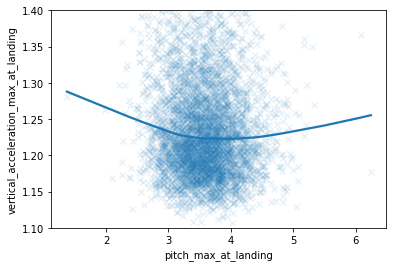

In [21]:
sns.regplot(x,y, lowess=True, marker='x', 
           scatter_kws={'alpha':0.1})
plt.ylim(1.1, 1.4)

/Users/ericleijonmarck/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


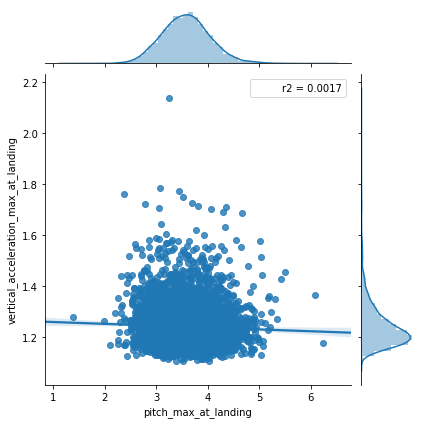

In [22]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(x, y, kind="reg", stat_func=r2)

/Users/ericleijonmarck/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


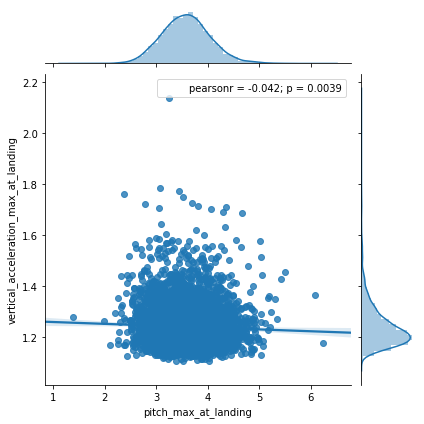

In [23]:
sns.jointplot(x, y, kind="reg");

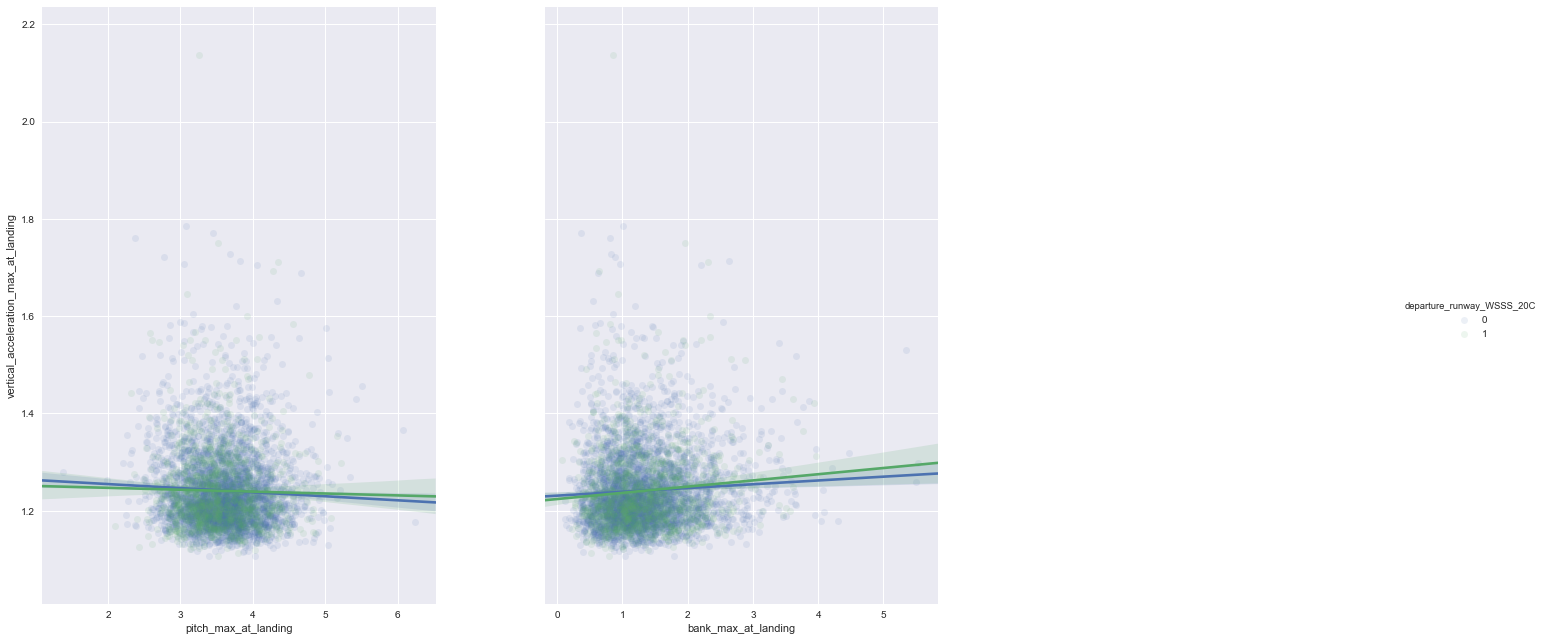

In [24]:

sns.set(color_codes=True)
categorical_variable = 'departure_runway_WSSS_20C'
df[categorical_variable] = pd.read_csv('current_processed.csv')[categorical_variable][0:df.shape[0]]
g = sns.pairplot(df, x_vars=["pitch_max_at_landing", "bank_max_at_landing"], y_vars=["vertical_acceleration_max_at_landing"],
             hue=categorical_variable, aspect=.8, kind="reg", plot_kws={'scatter_kws': {'alpha': 0.1}});

g.fig.set_size_inches(25,15)

In [ ]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = df.drop('vertical_acceleration_max_at_landing', axis=1)
y = df['vertical_acceleration_max_at_landing']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=42)

tpot = TPOTRegressor(generations=50, population_size=100, verbosity=0)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('hard_landing_scoot.py')